In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from sklearn.preprocessing import MinMaxScaler

import sys
sys.path.insert(0, "..")

from eis_toolkit.exploratory_analyses.pca import compute_pca

In [2]:
# Define filepaths
# NOTE: These files are placed in local and do not come with the repository automatically
AEM_quad_fp = "../tests/data/local/workflow_demo/IOCG_AEM_Quad.tif"
AEM_ratio_fp = "../tests/data/local/workflow_demo/IOCG_EM_ratio.tif"
Magn_AS_fp = "../tests/data/local/workflow_demo/Mag_DGRF_AS_FFT_ers_PCS_tif_clip.tif"
paths = [AEM_quad_fp, AEM_ratio_fp, Magn_AS_fp]

geochem_fp = "../tests/data/local/workflow_demo/Geochemical_Data/Vector_files/IOCG_CLB_Till_Geochem_reg_511p.shp"

PCA with rasters

In [3]:
# Read 3 rasters and stack them into a 3D numpy array for PCA input
raster_data = []
raster_metas = []
for path in paths:
    with rasterio.open(path) as raster:
        data = raster.read(1)  # All are singleband rasters
        data[data==raster.nodata] = np.nan  # Convert nodata to np.nan
        raster_data.append(data)
        raster_metas.append(raster.meta.copy())

raster_data[2] = raster_data[2][1:, :]  # Magnetic data had one more row, just cutting it out to have uniform shapes...

pca_input_array = np.stack(raster_data)
out_meta = raster_metas[0]

print(pca_input_array.shape)

(3, 1641, 1361)


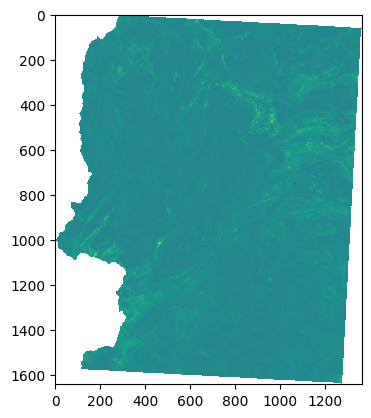

In [4]:
plt.imshow(pca_input_array[0])

In [5]:
out_array, explained_variances = compute_pca(pca_input_array, 3)
print(explained_variances)
print(out_array.ndim)

[0.42880431 0.36201539 0.2091803 ]
3


/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/niko/.local/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/tmp/ipykernel_827442/1619538750.py:14: Runtim

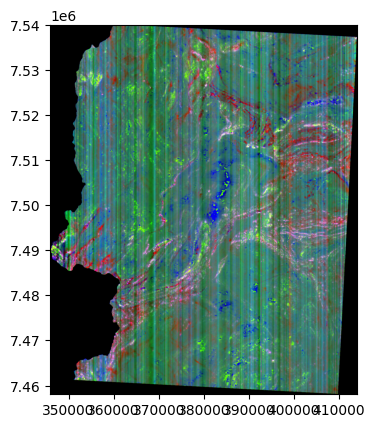

<Axes: >

In [6]:
# Normalize each band to 0-255 and display RGB plot
scaler = MinMaxScaler(feature_range=(0, 255))

# Reshape for scaler and scale each band
scaled_bands = []
for band in range(out_array.shape[0]):
    scaled_band = scaler.fit_transform(out_array[band])
    scaled_bands.append(scaled_band)

# Stack scaled bands back together
scaled_pca_output = np.stack(scaled_bands)

# Display the RGB image
show(scaled_pca_output.astype(np.uint8), transform=out_meta["transform"])

In [7]:
# Save raster to local/results to inspect in QGIS
out_meta["count"] = 3
path = "../tests/data/local/results/pca_test_result.tif"
with rasterio.open(path, "w", **out_meta) as dest:
    dest.write(out_array)

PCA with GDF

/home/niko/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


,principal_component_1,principal_component_2,principal_component_3,Year,geometry
0,19.648182,-5.991888,1.621838,81,POINT (404203.131 7526963.173)
1,0.765027,-4.030658,-1.370626,81,POINT (406827.101 7530497.757)
2,-3.497528,-3.958360,-1.827345,81,POINT (406536.240 7536878.222)
3,-4.341983,-3.717372,-1.588919,81,POINT (401544.178 7524138.307)
4,0.537943,-4.961354,-1.269606,81,POINT (405583.597 7530829.630)
...,...,...,...,...,...
1107,7.592129,4.758026,-1.011912,82,POINT (382172.995 7537670.981)
1108,14.477217,-2.188979,-1.161230,91,POINT (385765.473 7516725.298)
1109,17.992491,-2.548544,-0.969142,81,POINT (387888.646 7519737.094)
1110,27.386432,-2.115146,-1.129293,81,POINT (384556.012 7522850.859)


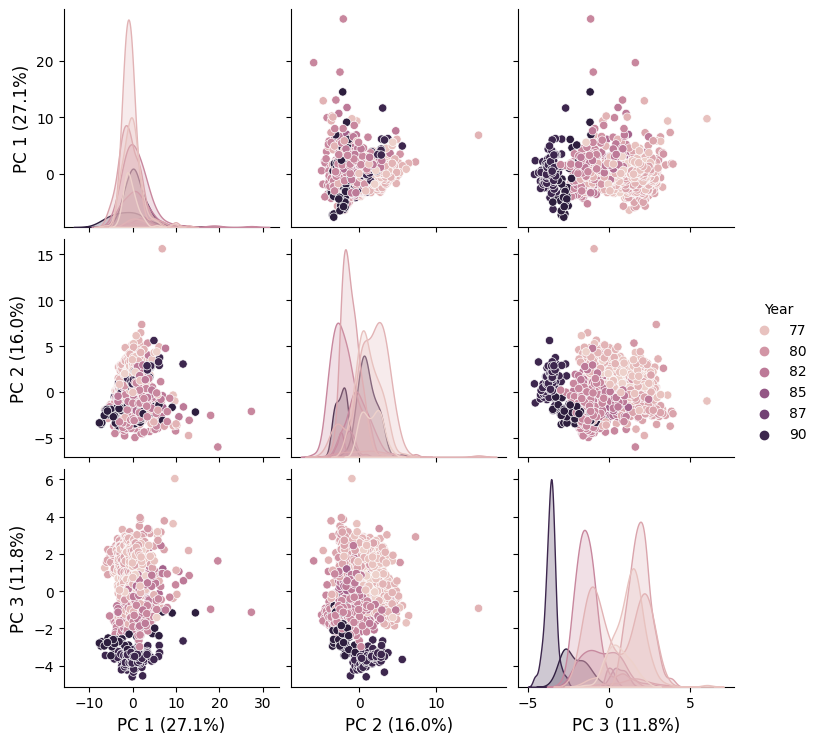

In [11]:
gdf = gpd.read_file(geochem_fp)

(result, plot), variances = compute_pca(gdf, number_of_components=3, color_column_name="Year")
result